[0, 1, 2, 3, 4, 5, 6, 7, 8]


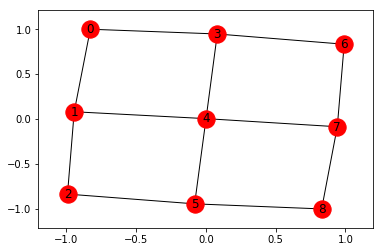

In [1]:
import numpy as np
import numpy.random as random

from pyquil.api import get_qc
from pyquil import Program
from pyquil.gates import *

from pyrethrum.random_operators import haar_rand_unitary

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

qc = get_qc("9q-square-noisy-qvm", as_qvm=True, noisy=True)

qubits = qc.qubits()
print(qubits)
graph = qc.qubit_topology()
nx.draw_networkx(graph, with_labels=True)

In [2]:
def bit_array_to_int(bit_array):
    output = 0
    for bit in bit_array:
        output = (output << 1) | bit
    return output

In [3]:
from pyquil.quil import DefGate
from pyquil.gates import I

def naive_program_generator(permutations, gates):
    depth = gates.shape[0]
    num_gates_per_layer = gates.shape[1]
    p = Program() # include all qubits in program
    for idx, (perm, layer) in enumerate(zip(permutations, gates)):
        for pair_idx, gate in enumerate(layer):

            # get the Quil definition for the new gate
            g_definition = DefGate("LYR" + str(idx) + "_RAND" + str(pair_idx), gate)
            # get the gate constructor
            G = g_definition.get_constructor()
            # add definition to program
            p += g_definition
            # add to program, acting on properly permuted qubits
            p += G(int(perm[pair_idx]), int(perm[pair_idx+1]))
    return p
    

In [4]:
from pyquil.api import WavefunctionSimulator

def collect_heavy_outputs(program, qubits):
    all_qubit_program = program.inst([I(int(q)) for q in qubits]) # ensures non-active qubits are reported
    wfn_sim = WavefunctionSimulator()
    wfn = wfn_sim.wavefunction(all_qubit_program)
    prob_dict = wfn.get_outcome_probs()
    
    sorted_by_prob = sorted([(bitstring, prob_dict[bitstring]) for bitstring in prob_dict], key=lambda pair:pair[1])
    heavy_outputs = [pair[0] for pair in sorted_by_prob][2**(len(qubits)-1):]
    assert(len(heavy_outputs) == 2**(len(qubits)-1))
    # convert heavy outputs to int
    base = np.array([2 ** i for i in range(len(qubits))])
    heavy_outputs = [np.sum(base * np.array([int(bit) for bit in output])) for output in heavy_outputs]
    return heavy_outputs

In [7]:
num_shots = 500
num_reps = 100

for depth in range(2,5):
    num_heavy = 0
    for _ in range(num_reps):
        qubits = np.arange(depth)
        num_gates_per_layer = depth//2
        permutations = [random.permutation(qubits) for layer in range(depth)]
        gates = np.array([haar_rand_unitary(4) 
                          for layer in range(depth) 
                          for pair in range(num_gates_per_layer)]).reshape((depth, num_gates_per_layer, 4, 4))
        program = naive_program_generator(permutations, gates)
        heavy_outputs = collect_heavy_outputs(program, qubits)

        ro = program.declare("ro", "BIT", len(qubits))
        for idx, qubit in enumerate(qubits):
            program.measure(int(qubit), ro[idx])
        program.wrap_in_numshots_loop(num_shots)
        executable = qc.compile(program)
        results = qc.run(executable)

        for result in results:
            # convert result to int for comparison with heavy outputs
            output = bit_array_to_int(result)
            if output in heavy_outputs:
                num_heavy += 1
    fraction = (num_heavy - 2 * np.sqrt(num_heavy * (num_shots - num_heavy/num_reps))) / (num_reps * num_shots)
    is_acheivable = fraction > 2/3
    print(fraction)
    print(is_acheivable)



0.6310128909637672
False
0.6604770344349515
False
0.5915570605156045
False
